In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
import requests

Import & Scrapping

In [ ]:
fred = '4c6126e875c9d02dfb10781331c01a2d'

In [ ]:
def get_gold_daily_stooq():
    url = "https://stooq.com/q/d/l/?s=xauusd&i=d"  # weekly langsung dari Stooq
    df = pd.read_csv(url)

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.rename(columns=str.lower)   # date, open, high, low, close, volume

    return df[["date","open","high","low","close"]].sort_values("date")

gold_df = get_gold_daily_stooq()

In [ ]:
gold_df = gold_df[gold_df["date"] >= pd.Timestamp("2020-01-01")].reset_index(drop=True)

In [ ]:
fred = '4c6126e875c9d02dfb10781331c01a2d'

In [ ]:
def get_fred_series(series_id, api_key, fif, start_years=5):
    """
    Download data FRED dalam format DataFrame
    """
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "frequency": fif,
        "observation_start": (datetime.now() - timedelta(days=start_years*365)).strftime("%Y-%m-%d"),
        "observation_end": datetime.now().strftime("%Y-%m-%d")
    }

    response = requests.get(url, params=params)
    data = response.json()

    # Add error handling
    if "observations" not in data:
        print(f"Error: 'observations' key not found for series_id: {series_id}")
        print("Full API Response:")
        print(data)
        return None # Return None if data is not in the expected format

    rows = []
    for obs in data["observations"]:
        value = obs["value"]
        rows.append({
            "date": obs["date"],
            "value": None if value == "." else float(value)
        })

    df = pd.DataFrame(rows)
    df["date"] = pd.to_datetime(df["date"])
    df = df.dropna().reset_index(drop=True)

    return df

preprocess

In [ ]:
dxy_df = get_fred_series("DTWEXBGS", fred, 'd', start_years=5)

df = pd.merge(gold_df, dxy_df, on="date")

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')  # urutin tanggal
df.set_index('date', inplace=True)

In [ ]:
df = df.apply(pd.to_numeric, errors='coerce')

In [ ]:
df = df.rename(columns={'value':'dxy'})

In [ ]:
df

,open,high,low,close,dxy
date,,,,,
2020-12-09,1870.930,1870.930,1825.940,1840.060,112.0353
2020-12-10,1839.840,1849.990,1828.890,1836.790,111.9839
2020-12-11,1837.380,1847.740,1824.760,1839.500,112.1469
2020-12-14,1841.460,1841.460,1820.170,1827.120,112.1770
2020-12-15,1827.790,1855.390,1825.660,1853.360,111.8660
...,...,...,...,...,...
2025-11-21,4074.985,4100.635,4023.795,4068.485,122.2350
2025-11-24,4069.380,4139.975,4040.245,4135.520,122.2833
2025-11-25,4134.105,4159.015,4110.535,4130.665,122.0044


In [ ]:
 # Only clean the feature column (dxy)
df['dxy'] = df['dxy'].ffill().bfill()

# Remove any duplicated index just in case
df = df[~df.index.duplicated(keep='first')]

eda

In [ ]:
# pastikan data terurut
df = df.sort_values("date").reset_index(drop=False)

In [ ]:
# ==== 1. Info dasar dataset ====
print("=== Info Dataset ===")
print(df.info())
print("\n=== Statistik Deskriptif ===")
print(df.describe())

=== Info Dataset ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1237 entries, 2020-12-09 to 2025-11-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1237 non-null   float64
 1   high    1237 non-null   float64
 2   low     1237 non-null   float64
 3   close   1237 non-null   float64
 4   dxy     1237 non-null   float64
dtypes: float64(5)
memory usage: 58.0 KB
None

=== Statistik Deskriptif ===
              open         high          low        close          dxy
count  1237.000000  1237.000000  1237.000000  1237.000000  1237.000000
mean   2233.347296  2250.253023  2217.594248  2234.804208   120.018924
std     611.605859   619.794120   604.790780   613.976880     4.643586
min    1622.940000  1641.035000  1614.905000  1622.805000   110.517900
25%    1813.440000  1824.290000  1803.850000  1812.230000   116.120800
50%    1946.300000  1959.865000  1934.450000  1946.210000   120.875200
75%    2511.825000  252

In [ ]:
# ==== 2. Missing value check ====
print("\n=== Missing Value ===")
print(df.isnull().sum())


=== Missing Value ===
date     0
open     0
high     0
low      0
close    0
dxy      0
dtype: int64


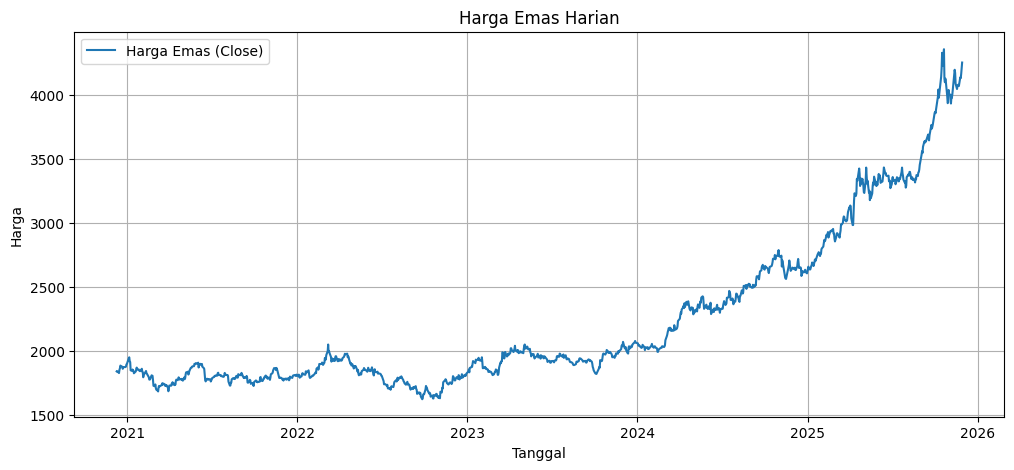

In [ ]:
# ==== 3. Plot harga emas ====
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["close"], label="Harga Emas (Close)")
plt.title("Harga Emas Harian")
plt.xlabel("Tanggal"); plt.ylabel("Harga"); plt.grid(True); plt.legend()
plt.show()

model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Fungsi evaluasi (tanpa MAPE)
# -------------------------
def eval_model(y_true, y_pred, name=""):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name:20s} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


# ==========================================================
# 0. Data awal
# df harus punya kolom: ['date','close','dxy', ...]
# ==========================================================
df = df.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

# MA3 (tren halus)
df['ma3'] = df['close'].rolling(3).mean()

# 🎯 TARGET: ΔMA3 = MA3_{t+1} - MA3_t
df['target'] = df['ma3'].shift(-1) - df['ma3']

# Fitur: lag dari close, ma3, dxy (bisa tambah lain kalau mau)
feature_cols = ['close', 'ma3', 'dxy']
lags = [1, 3, 7, 14]

for col in feature_cols:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# buang NaN akibat rolling & lag
df = df.dropna()

# y = ΔMA3, X = fitur-fitur lag
y = df['target']
X = df.drop(columns=['target', 'ma3', 'close', 'dxy'])  # cuma pakai lag2 sebagai fitur

print("Shape X:", X.shape)

Shape X: (1220, 15)


In [ ]:
# ==========================================================
# 1. Train–Test Split
# ==========================================================
split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train: {len(y_train)}, Test: {len(y_test)}")

# Naive: ΔMA3 besok = 0 (MA3 besok sama dengan hari ini)
naive_train = np.zeros_like(y_train)
naive_test  = np.zeros_like(y_test)


Train: 976, Test: 244


In [ ]:
# ==========================================================
# 2. ARIMAX (ΔMA3 target)
# ==========================================================
print("\n=== ARIMAX (ΔMA3 target) ===")

arimax_model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 0, 1),          # d=0 karena target sudah 'delta'
    enforce_stationarity=False,
    enforce_invertibility=False
)

arimax_res = arimax_model.fit(disp=False)

# in-sample
y_pred_arimax_train = arimax_res.fittedvalues
y_pred_arimax_train = y_pred_arimax_train.loc[y_train.index]

# out-of-sample
y_pred_arimax_test = arimax_res.forecast(
    steps=len(y_test),
    exog=X_test
)
y_pred_arimax_test.index = y_test.index

# evaluasi ΔMA3
eval_model(y_train, naive_train,         "Naive (Train)")
eval_model(y_test,  naive_test,          "Naive (Test)")
eval_model(y_train, y_pred_arimax_train, "ARIMAX (Train)")
eval_model(y_test,  y_pred_arimax_test,  "ARIMAX (Test)")


=== ARIMAX (ΔMA3 target) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Naive (Train)        -> MAE: 7.8114, RMSE: 10.2748, R²: -0.0051
Naive (Test)         -> MAE: 19.0627, RMSE: 25.6484, R²: -0.0645
ARIMAX (Train)       -> MAE: 4.7234, RMSE: 6.3460, R²: 0.6166
ARIMAX (Test)        -> MAE: 11.1227, RMSE: 15.1600, R²: 0.6281


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# ==========================================================
# 3. Rekonstruksi MA3 & Harga Absolut dari ΔMA3 Prediksi
#    (supaya nyambung sama judul "prediksi harga emas")
# ==========================================================

# ambil MA3 actual hari terakhir (MA3_t)
ma3_today = df['ma3'].iloc[-1]

# ambil prediksi delta untuk hari terakhir di test (ΔMA3_t)
# ini prediksi perubahan MA3 dari hari terakhir → hari besok
delta_pred = y_pred_arimax_test.iloc[-1]

# MA3 prediksi besok: MA3_{t+1} = MA3_t + ΔMA3_t
ma3_pred_tomorrow = ma3_today + delta_pred

# ambil harga close(t) dan close(t-1)
close_t   = df['close'].iloc[-1]
close_tm1 = df['close'].iloc[-2]

# rekonstruksi harga absolut besok:
# MA3_{t+1} = (close_{t+1} + close_t + close_{t-1}) / 3
# => close_{t+1} = 3*MA3_{t+1} - close_t - close_{t-1}
close_pred_tomorrow = 3 * ma3_pred_tomorrow - close_t - close_tm1

print("\nPrediksi harga emas (close) besok:", close_pred_tomorrow)


Prediksi harga emas (close) besok: 4174.289984767248


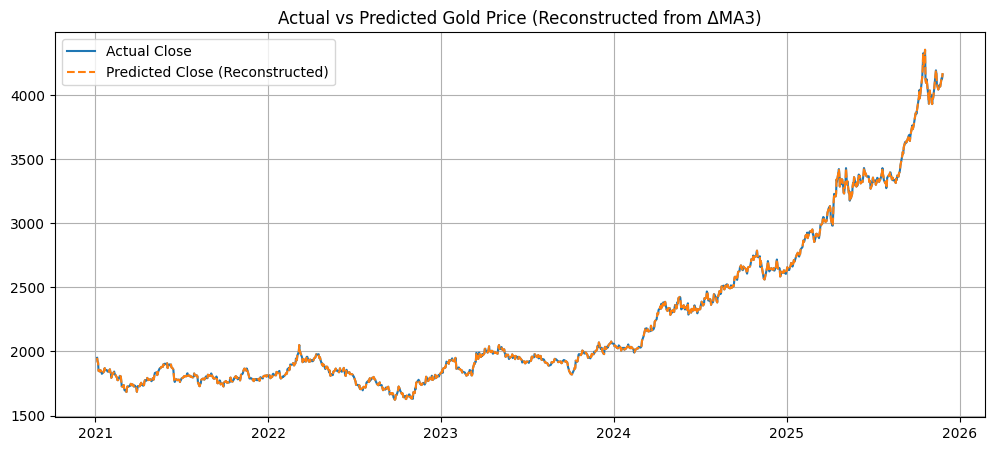

In [ ]:
# ==========================================================
# 4. Buat DataFrame Prediksi untuk Visualisasi
# ==========================================================
df_pred = df.copy()

# kolom MA3 prediksi (isi sama seperti MA3 actual, kecuali baris terakhir)
df_pred['ma3_pred'] = df_pred['ma3']
df_pred.iloc[-1, df_pred.columns.get_loc('ma3_pred')] = ma3_pred_tomorrow

# kolom harga prediksi (sama seperti close, kecuali baris terakhir)
df_pred['close_pred'] = df_pred['close']
df_pred.iloc[-1, df_pred.columns.get_loc('close_pred')] = close_pred_tomorrow

# plot harga actual vs harga prediksi (hanya titik terakhir beda)
plt.figure(figsize=(12, 5))
plt.plot(df_pred['close'], label='Actual Close')
plt.plot(df_pred['close_pred'], label='Predicted Close (Reconstructed)', linestyle='--')
plt.legend()
plt.title("Actual vs Predicted Gold Price (Reconstructed from ΔMA3)")
plt.grid(True)
plt.show()